# imports

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import time 
import glob
import re
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# import sys
# sys.path.append('/root/digital-twin/wireless_digital_twin/')

import tensorflow as tf
print(tf.test.gpu_device_name())

import utils.utilfunc as uf
import utils.datagen as dg
from utils.models import PlanNet, RouteNet


2023-03-26 16:45:39.323431: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-26 16:45:39.475853: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-26 16:45:41.292267: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriat

/device:GPU:0


# Config Files and Data Loaders

In [117]:
cfg_file = './configs/nsf-delay.ini'
config  = uf.PathConfigParser(cfg_file).as_dict()
hparams = dict(**config['GNN'], **config['LearningParams'])

datagens, datasets = dg.get_data_gens_sets(config)
print(datagens["train"].n)
config

PlanDataGensMulti: ['./dataset/NsfnetR1S1St180Dr150/train/paths.txt']
PlanDataGensMulti: ['./dataset/NsfnetR1S1St180Dr150/validate/paths.txt']
PlanDataGensMulti: ['./dataset/NsfnetR1S1St180Dr150/test/paths.txt']
input_argws_set: {'output_types': ({'n_paths': tf.int32, 'n_links': tf.int32, 'n_nodes': tf.int32, 'n_total': tf.int32, 'paths_to_links': tf.int32, 'links_to_paths': tf.int32, 'sequences_paths_links': tf.int32, 'links_to_nodes': tf.int32, 'nodes_to_links': tf.int32, 'sequences_links_nodes': tf.int32, 'paths_to_nodes': tf.int32, 'nodes_to_paths': tf.int32, 'sequences_nodes_paths': tf.int32, 'laplacian_matrix': tf.float32, 'adjacency_matrix': tf.float32, 'node_init': tf.float32, 'path_init': tf.float32, 'link_init': tf.float32}, {'delay': tf.float32, 'drops': tf.float32, 'drop-rate': tf.float32, 'drop-bi': tf.float32, 'jitter': tf.float32, 'throughput': tf.float32}), 'output_shapes': ({'n_paths': TensorShape([]), 'n_links': TensorShape([]), 'n_nodes': TensorShape([]), 'n_total': 

{'Paths': {'data': ['./dataset/NsfnetR1S1St180Dr150'],
  'graph': ['./dataset/nsfnet.gml'],
  'logs': ['./output/logs/'],
  'routing': ['paths.txt'],
  'trainon': ['delay']},
 'GNN': {'T': 3,
  'link_state_dim': 16,
  'path_state_dim': 32,
  'node_state_dim': 16,
  'readoutLayerSizes': [16, 32, 16],
  'edgeMLPLayerSizes': [8, 16, 32, 16, 8]},
 'LearningParams': {'epochs': 100,
  'learning_rate': 0.001,
  'lr_decay_steps': 10000,
  'lr_decay_rate': 0.95,
  'batch_size': 100,
  'dropout_rate': 0.1,
  'l2': 10,
  'l2_2': 1,
  'learn_embedding': True}}

# Models

In [118]:

model = PlanNet(hparams, train_on=config['Paths']['trainon'])
# model = RouteNet(hparams, train_on = config['Paths']['trainon'])
mclass = re.findall('\'.+\..+\.(.+)\'', str(model.__class__))[0] #<class 'utils.models.PlanNet'>

model.build()
opt = tf.keras.optimizers.Adam(learning_rate=hparams['learning_rate'])
model.compile(optimizer= opt, run_eagerly=False)

# save model
model_dirname = 'TRG+' + model.train_on + '_DS+' + '+'.join(
#     [' '.join(re.split('_|-',os.path.basename(d))).title().replace(' ', '') for d in config['Paths']['data']]
    [os.path.basename(d) for d in config['Paths']['data']]
)
checkpoint_dir = os.path.join(config['Paths']['logs'][0], mclass, model_dirname)#+"_run2_800")
checkpoint_path_best = os.path.join(checkpoint_dir, "cp-best.ckpt")
csvlog_path = os.path.join(checkpoint_dir, "training.log")

model(datagens['train'].__getitem__(0)[0])


<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[ 0.01067711],
       [-0.04130696],
       [-0.06564321],
       [-0.06285229],
       [-0.06914783],
       [-0.02765081],
       [-0.10654638],
       [-0.10960989],
       [-0.03590085],
       [-0.18640904]], dtype=float32)>

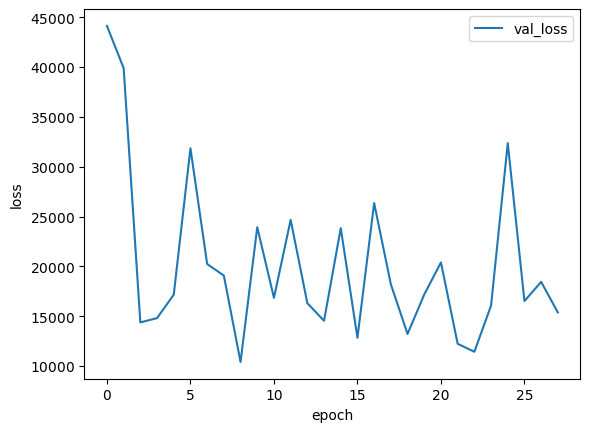

In [130]:
fig, ax = plt.subplots(1,1)
# ax.plot(train_loss_proc, label='train_loss')
# ax.plot(val_loss_proc, label='val_loss')
df_disp = pd.read_csv(csvlog_path)[['epoch', 'loss', 'val_loss']]
i0 = np.where(df_disp.epoch.values==0)[0][-1]
df_disp[['val_loss']][i0:].plot(ax=ax)

plt.legend()
plt.ylabel('loss')
plt.xlabel('epoch')

from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
# formatter.set_powerlimits((-1,1)) 
ax.yaxis.set_major_formatter(formatter) 

# plt.ylim([None, 200000])

In [122]:

# Restore the checkpointed values
model.load_weights(checkpoint_path_best)
# ckpt = tf.train.Checkpoint(model)
# ckpt.restore(checkpoint_path_best)

##
metrics_mae = []
y_true = []
y_pred = []

for cnt, (inp, lab) in enumerate(datagens['validate']):
    t_start = time.time()
    if 0:#lab[model.train_on].numpy().mean() < 200:
        continue
    y_true.append(lab[model.train_on])
    y_pred.append(model(inp).numpy().squeeze())
    t_end = time.time()
    print(cnt, 'used time {}s'.format(t_end - t_start), end = '\r')
    
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
metrics_mae = np.abs(y_pred - y_true)
err = metrics_mae/y_true

print(cnt, "MAE = {:.2f} ({:.2f}), Err% = {:.2%} ({:.2%})".format(
    np.nanmean(metrics_mae), np.nanstd(metrics_mae),
    np.nanmean(err[~np.isinf(err)]), np.nanstd(err[~np.isinf(err)]), 
))
np.corrcoef(y_true, y_pred)

198 MAE = 101.45 (118.80), Err% = 39.10% (106.85%)


array([[1.        , 0.85537104],
       [0.85537104, 1.        ]])

In [123]:
## ns3 results

lab2idx = {
    'delay':2, 'jitter':3, 'throughput':4, 
    'drops':None, 'drop-bi':None, 'drop-rate':None
}

ns3_rfile = config['Paths']['data'][0]+'/validate/kpis_val1.txt'
y_ns3 = []
with open(ns3_rfile, 'r') as f:
    for l in f.readlines():
        if 'drop' not in model.train_on:
            y_ns3 += [float(i) for i in l.replace('\n','').split(',')[lab2idx[model.train_on]::5]]
        else:
            tx = [float(i) for i in l.replace('\n','').split(',')[0::5]]
            rx = [float(i) for i in l.replace('\n','').split(',')[1::5]]
            if model.train_on == 'drops':
                y_ns3 += [t-r for t,r in zip(tx,rx)]
            elif model.train_on == 'drop-rate':
                y_ns3 += [(t-r)/(t+1e-10) for t,r in zip(tx,rx)]
            elif model.train_on == 'drops-bi':
                y_ns3 += [((t-r)/(t+1e-10))>.1 for t,r in zip(tx,rx)]
            
y_ns3 = np.array(y_ns3)
print(y_ns3.shape)

ni = min(len(y_ns3), len(y_true))
mae = np.abs(y_ns3[:ni] - y_true[:ni])
mae.mean(), mae.std()


(1990,)


(100.33517587939699, 174.71303311011718)

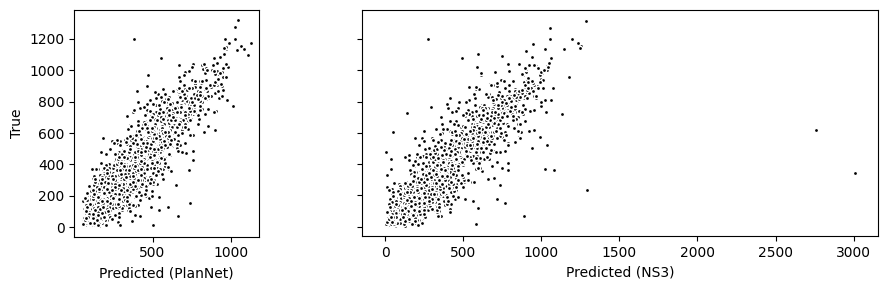

In [93]:

fig, axes = plt.subplots(1, 2, figsize=(10,3), sharey=True)
axes[0].plot(
    y_pred, y_true, color='black', marker='o', alpha=1, 
    markeredgecolor='white',linestyle='',markersize=3
)
try:
    axes[1].plot(
        y_ns3[:ni], y_true[:ni], color='black', marker='o', alpha=1, 
        markeredgecolor='white',linestyle='',markersize=3
    )
except:
    pass
[ax.set_aspect('equal') for ax in axes]
axes[0].set_xlabel('Predicted (PlanNet)')
axes[0].set_ylabel('True')
axes[1].set_xlabel('Predicted (NS3)')

# plt.xlabel('Predicted drops %')
# plt.ylabel('True drops %')

# axes[0].set_xlim([-100,1300])
# axes[0].set_ylim([-100,1300])
plt.tight_layout()
plt.show()

